# FarmOG Station - Fusion System Demo
## Testing all 3 detection modes

In [1]:
import sys
import numpy as np
import json
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

sys.path.append('..')

import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from src.fusion_engine import FarmOGFusionEngine
from src.sensor_matcher import get_top_risks
from src.disease_siganture import get_disease_display_name

# Load model
model = tf.keras.models.load_model('models/farmog_resnet50v2_classifier.h5')
with open('models/class_names.json') as f:
    class_names = json.load(f)

fusion = FarmOGFusionEngine(model, class_names)
print('✅ Fusion engine loaded')

✅ Fusion engine loaded


## Test Case 1: Vision Only

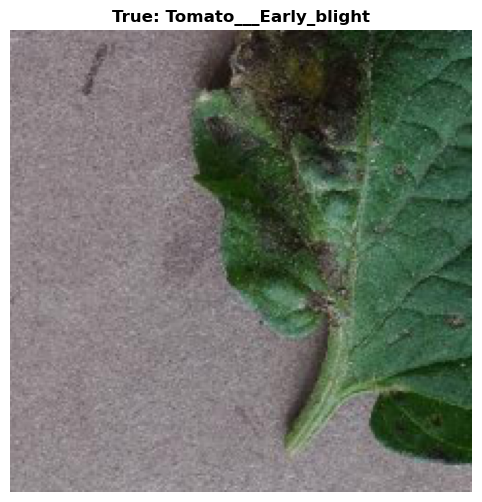

Vision Predictions:
  Early Blight: 100.0%


In [2]:
# Load test image
import random
valid_dir = Path('../data/raw/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid')
test_class = 'Tomato___Early_blight'
images = list((valid_dir / test_class).glob('*.jpg'))
img_path = random.choice(images)

# Preprocess
img = Image.open(img_path).resize((224, 224))
img_array = preprocess_input(np.array(img))

# Predict
vision_results = fusion.predict_from_image(img_array)
top_preds = fusion.get_top_vision_predictions(vision_results, top_n=3)

# Display
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f'True: {test_class}', fontweight='bold')
plt.axis('off')
plt.show()

print('Vision Predictions:')
for disease, conf in top_preds:
    print(f'  {get_disease_display_name(disease)}: {conf*100:.1f}%')

## Test Case 2: Sensor Only

In [3]:
# Conditions favorable for Late Blight
sensor_data = {
    'air_temp': 15,
    'air_humidity': 92,
    'soil_moisture': 80,
    'rainfall_24h': 15,
    'irrigation_method': 'overhead'
}

risks = get_top_risks(sensor_data, top_n=3)

print('Sensor Risk Assessment:')
for disease, risk in risks:
    if risk > 20:
        print(f'  {get_disease_display_name(disease)}: {risk:.1f}%')

Sensor Risk Assessment:
  Late Blight: 100.0%
  Bacterial Spot: 70.0%
  Septoria Leaf Spot: 65.0%


## Test Case 3: Fusion (Confirmed)

In [4]:
# Match vision + sensor for Early Blight
sensor_early_blight = {
    'air_temp': 27,
    'air_humidity': 85,
    'soil_moisture': 75,
    'rainfall_24h': 5,
    'irrigation_method': 'overhead'
}

diagnosis = fusion.cross_validate(vision_results, sensor_early_blight)

print('='*60)
print('FUSION DIAGNOSIS')
print('='*60)
print(f"Final: {get_disease_display_name(diagnosis['final_diagnosis'])}")
print(f"Confidence: {diagnosis['confidence']:.1f}%")
print(f"Status: {diagnosis['status']}")

if diagnosis['confirmed']:
    print('\nConfirmed diagnosis - Vision and Sensor agree!')
    print(f"Root Cause: {diagnosis['confirmed'][0]['root_cause']}")

FUSION DIAGNOSIS
Final: Early Blight
Confidence: 95.0%
Status: CONFIRMED

Confirmed diagnosis - Vision and Sensor agree!
Root Cause: Warm humid conditions + poor airflow favor Alternaria fungus


## Test Case 4: Early Warning

In [5]:
# Healthy plant but risky conditions
test_healthy = 'Tomato___healthy'
images_healthy = list((valid_dir / test_healthy).glob('*.jpg'))
img_healthy = Image.open(random.choice(images_healthy)).resize((224, 224))
img_healthy_array = preprocess_input(np.array(img_healthy))

vision_healthy = fusion.predict_from_image(img_healthy_array)

# High risk sensor data
risky_conditions = {
    'air_temp': 16,
    'air_humidity': 93,
    'soil_moisture': 85,
    'rainfall_24h': 20,
    'irrigation_method': 'overhead'
}

early_warning = fusion.cross_validate(vision_healthy, risky_conditions)

print('EARLY WARNING TEST')
print('='*60)
print(f"Status: {early_warning['status']}")
if early_warning['early_warnings']:
    print(f"Alert: {early_warning['early_warnings'][0]['alert']}")
    print('\nPreventive actions can stop disease before symptoms appear!')

EARLY WARNING TEST
Status: EARLY_WARNING
Alert: ⚠️ Conditions favor Late Blight - symptoms may appear in 24-48h

Preventive actions can stop disease before symptoms appear!


## Summary Report

In [6]:
print('='*60)
print('FUSION SYSTEM CAPABILITIES')
print('='*60)
print('\n✅ Vision Only: 98.74% accuracy')
print('✅ Sensor Only: Environmental risk assessment')
print('✅ Fusion Confirmed: Cross-validated diagnosis')
print('✅ Early Warning: Detect conditions 24-48h before symptoms')
print('✅ Conflict Detection: Handle disagreements intelligently')
print('\nAll 3 modes operational and tested!')

FUSION SYSTEM CAPABILITIES

✅ Vision Only: 98.74% accuracy
✅ Sensor Only: Environmental risk assessment
✅ Fusion Confirmed: Cross-validated diagnosis
✅ Early Warning: Detect conditions 24-48h before symptoms
✅ Conflict Detection: Handle disagreements intelligently

All 3 modes operational and tested!
